# Data Analysis & Visualisation using names

This example uses the US Baby Names dataset (http://www.ssa.gov/oact/babynames/limits.html) that has male and female names with the corresponding number of births for each year from 1880 to 2024. Much of the analysis is reused from the Python for Data Analysis book by Wes McKinney (O'Reilly, 2012)

First download the dataset and read the names from 1880 into a pandas dataframe. The yob1880.txt file is in CSV format with name, sex (M or F) and the number of births.

In [118]:
import pandas as pd
import numpy as np

In [120]:
names1880 = pd.read_csv('usnames/yob1880.txt', names=['name', 'sex', 'births'])

In [122]:
names1880.head()

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


The previous cell shows the first 5 entries to illustrate how the data from the 1880 file is structured. Clearly Mary was very popular!

Let's find out how many total female (F) and male (M) births there were in 1880. Note that this dataset only includes names that were used 5 or more times so this won't be the actual number.

In [7]:
names1880.groupby('sex').births.sum()

sex
F     90994
M    110490
Name: births, dtype: int64

So how popular was Mary in 1880 - as a proportion of the total number of female births?

In [10]:
mary1880 = names1880[names1880.name == 'Mary']

In [12]:
mary1880

,name,sex,births
0,Mary,F,7065
1273,Mary,M,27


Ok, so there were some boys named 'Mary' in 1880! Let's ignore those and just look at the girls

In [14]:
mary1880F = mary1880[mary1880.sex == 'F']

In [16]:
mary1880F

,name,sex,births
0,Mary,F,7065


In [18]:
mary1880F.births / names1880.groupby('sex').births.sum()['F'] * 100

0    7.764248
Name: births, dtype: float64

So almost 8 in every 100 females born in 1880 were named 'Mary'.

In [21]:
mary1880[mary1880.sex == 'M'].births / names1880.groupby('sex').births.sum()['M'] * 100

1273    0.024437
Name: births, dtype: float64

And just over 2 in every 10,000 boys born in 1880 were named 'Mary' :-)

Let's get all of the years into a dataframe to look at trends over time. Each set is in a separate text file named yobYYYY.txt where YYYY is the year. We can make a [range](https://docs.python.org/2/library/functions.html#range) (years) from 1880 to 2010 and then [loop](https://docs.python.org/2/reference/compound_stmts.html#for) over the files [reading the data](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html?highlight=read_csv#pandas.read_csv) into a frame and storing each in a [list](https://docs.python.org/2/library/functions.html#list) before [concatenating](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html?highlight=concat#pandas.concat) everything into a dataframe.

In [113]:
years = range(1880, 2024)
pieces = []
columns = ['name', 'sex', 'births']
for year in years:
    path = 'usnames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    frame['year'] = year
    pieces.append(frame)
# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

In [63]:
names.head(5)  # just show the first 5

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [115]:
names.to_csv('usnames.csv', index=False)

Now we have a total dataframe (names) that has the name, sex, number of births and the year. Lets look at the total number of births (male & female) for each year using the [pivot_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html?highlight=pivot_table#pandas.pivot_table) operation.

In [65]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc="sum")

In [67]:
total_births.tail() # show the last 5 years

sex,F,M
year,,
2019,1676568,1792223
2020,1614196,1723649
2021,1638188,1746499
2022,1636657,1741954
2023,1596022,1701224


To see what this looks like, we'll make a [plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html?highlight=plot#pandas.DataFrame.plot) (a line graph) showing the number of births by sex and year.

In [57]:
%matplotlib inline 

<Axes: title={'center': 'Total births by sex and year'}, xlabel='year'>

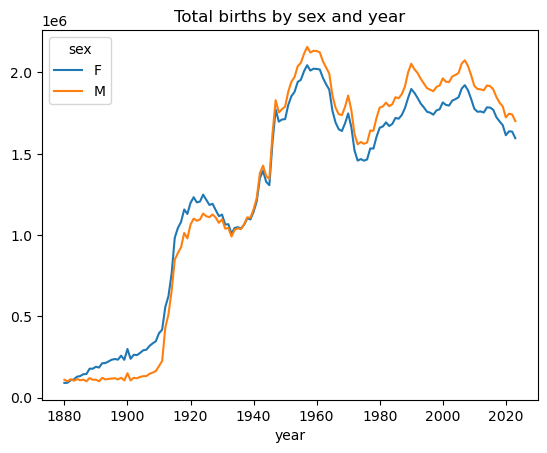

In [69]:
total_births.plot(title='Total births by sex and year')

Let's look at some trends by adding a column to the dataframe that records the proportion of births with that name in that year. Group the data by year and sex, then add the new column 'prop' to each group.

In [109]:
def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)
    group['prop'] = births / births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop, include_groups=False)

In [111]:
names.head(5)

name  births      prop
year sex                               
1880 F   0       Mary    7065  0.077642
         1       Anna    2604  0.028617
         2       Emma    2003  0.022012
         3  Elizabeth    1939  0.021309
         4     Minnie    1746  0.019188

It's a good idea to check that we have calculated this correctly (often called a 'sanity check') by verifying that all of the prop values in a group add up to a total of 1.0. Because we're using floating point values a function like [np.allclose](http://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) is best as there could be small variations.

In [ ]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

So our group calculation looks to be correct.

Next we'll get a subset of the data - the top 1000 names for each year/sex. There's a few different ways to do this.

In [ ]:
pieces = []
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_index(by='births', ascending=False)[:1000])
top1000 = pd.concat(pieces, ignore_index=True)

In [ ]:
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)
table.head()

sex,F,M
year,,
1880,1.000000,0.997375
1881,1.000000,1.000000
1882,0.998702,0.995646
1883,0.997596,0.998566
1884,0.993156,0.994539


Using this we can examine things like the change in naming diversity. 

Plot the total proportion of names from the top 1000.

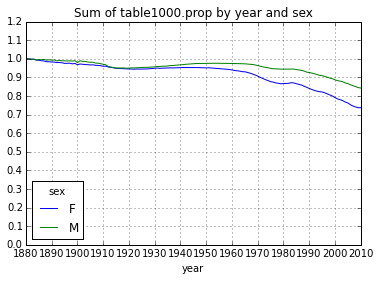

In [ ]:
table.plot(title='Sum of table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

So we can see that there is a decreasing total proportion of names from the top 1000 indicating that parents are choosing a greater variety of names - especially for girls.

### Ideas for other explorations
1. Plot the changing proportion for your own name.
2. Try to change the look of the plots - a bar plot, different colours etc.
3. Plot the changing proportions over the years for specific names like 'Mary', 'John' etc.
4. Find examples of names that are used for both boys and girls (unisex) and plot their changing distribution to find where they change over. Are there any names that move from being mostly girls to mostly boys?
5. Examine the 'Last Letter' revolution where it has been noted that the distribution of girls and boys names by the final letter has changed over the last 100 years. Particularly boys names ending in 'd', 'n' & 'y'.
6. The Irish baby names data is also available for the years 1998 to 2013 from the Central Statistics Office. You will need to wrangle the data into a useful dataframe before analysing it.